### Цель ноутбука показать как из размеченных сегментационных картинок (картинка + полигон вокруг пузыря) сделать датасет для обучения сегментационной сети

In [2]:
import json

In [3]:
import matplotlib.pyplot as plt

In [4]:
import cv2 as cv

In [5]:
def flood_fill(edge, dots):
    attempt = 1
    sign = 1
    max_square = 0
    the_best = None
    while attempt <= 10 and len(dots) > attempt:
        dot1 = dots[0]
        dot2 = dots[min(attempt, len(dots)-1)]
        dot = ((dot1[0]+dot2[0])//2,(dot1[1]+dot2[1])//2)
        dot = [max(0, dot[0]), max(0,dot[1])]
        dot = (400,400)#(min(dot[0],edge.shape[0]-1), min(dot[1], edge.shape[1]-1))
        
        im_flood_fill = edge.copy()
        h, w = edge.shape[:2]
        mask = np.zeros((h + 2, w + 2), np.uint8)
        im_flood_fill = im_flood_fill.astype("uint8")

        im_flood_fill=cv.floodFill(im_flood_fill, mask, dot, 1)[1].astype('float')
        if np.mean(im_flood_fill) > 0.85: # and np.mean(im_flood_fill) < 0.85:
            im_flood_fill = 1 - im_flood_fill
        elif im_flood_fill[0,0] > 0 or im_flood_fill[-1,-1] > 0 or im_flood_fill[-1,0] > 0 or im_flood_fill[0,-1] > 0:  # these points should be defintely zero!
            im_flood_fill[:] = 0
        
        if max_square < np.mean(im_flood_fill):
            max_square = np.mean(im_flood_fill)
            the_best = im_flood_fill
        #if np.mean(im_flood_fill) > 0.0007:
            #print(np.mean(im_flood_fill))
        #return im_flood_fill
        
        attempt += 1
        #sign = (-1) * sign
    
    #print("Faul")
    return the_best


def make_seg_map(seg_map, edges, x,y):
    l = list(zip(x,y))
    #|print(len(l))
    vectors = []
    dots = []
    
    edge = np.zeros(seg_map.shape[0:2])
    #edge[0,:] = 1
    #edge[:,0] = 1
    #edge[-1,:] = 1
    #edge[:,-1] = 1
    
    for i in range(1, len(l)+1):
        x1 = l[i-1][0]
        y1 = l[i-1][1]
        if i == len(l):
            x2 = l[0][0]
            y2 = l[0][1]
        else:
            x2 = l[i][0]
            y2 = l[i][1]


        dots.append((int(x1),int(y1)))

        ls = np.linspace((y1,x1), (y2,x2),num=2*int(np.sqrt((x2-x1)**2+(y2-y1)**2)))
        #print(ls)
        for ll in ls:
            #print(ll[0])
            ll = [int(ll[0]), int(ll[1])]
            ll[0] = max(0, ll[0])
            ll[1] = max(0, ll[1])
            
            ll[0] = min(edge.shape[0]-1, ll[0])
            ll[1] = min(edge.shape[1]-1, ll[1])
            edge[ll[0], ll[1]] = 1.0
       
        
    
    im_flood_fill = flood_fill(edge, dots)
    
    edges += edge
    #if np.mean(im_flood_fill > 0.0005):
        
    
    #print(im_flood_fill.mean())
    if im_flood_fill is not None:
        seg_map += im_flood_fill
    #plt.imshow(im_flood_fill)
    return seg_map, edges
    #print(im_flood_fill)

In [6]:
#mask.shape

In [7]:
# import cv2 as cv
# im_flood_fill = seg_map.copy()
# h, w = seg_map.shape[:2]
# mask = np.zeros((h + 2, w + 2), np.uint8)
# im_flood_fill = im_flood_fill.astype("uint8")
# plt.imshow(cv.floodFill(im_flood_fill, mask, (150, 75), 255)[1])

In [8]:
import numpy as np
#np.mean(results)

In [9]:
DATASET_PATH = "./dataset/"

In [10]:
import os
imgs = [x[:-4] for x in os.listdir(DATASET_PATH) if 'jpg' in x]

In [11]:
it = iter(range(0,len(imgs)))

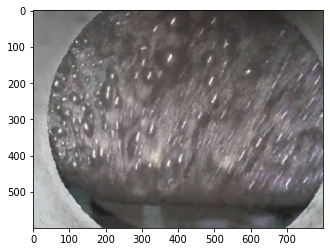

In [15]:
index=next(it)
img = plt.imread(DATASET_PATH+imgs[index]+".jpg")

with open(DATASET_PATH+imgs[index]+".json", "r") as file:
    ann = json.load(file)

import numpy as np
plt.imshow(img)
seg_map = np.zeros(img.shape[0:2])
edges = np.zeros(img.shape[0:2])
for i in range(0, len(ann['annotations'])):
    x=ann['annotations'][i]['segmentation'][0][::2]
    y=ann['annotations'][i]['segmentation'][0][1::2]
    x.append(x[0])
    y.append(y[0])
    seg_map, edges=make_seg_map(seg_map, edges, x,y)
    #plt.plot(x,y, c='white')
    #break
seg_map=np.where(seg_map>1,1, seg_map)
#plt.imshow(seg_map)

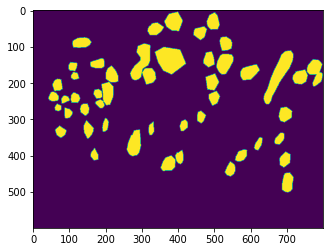

In [16]:
plt.imshow(seg_map)

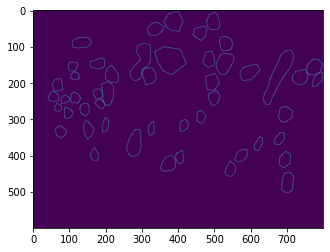

In [17]:
plt.imshow(edges)

### Отлично! В @seg_map содержится сегментационная карта пузырей, и она полностью соответствует ребрам @edges